In [ ]:
!pip install deepxde


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.4 MB/s eta 0:00:00


In [ ]:
import os
os.environ['DDE_BACKEND'] = 'pytorch'

In [ ]:
import deepxde as dde
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [ ]:
def pde(x, u):
  du_t = dde.grad.jacobian(u, x, i=0, j=1)
  du_xx = dde.grad.hessian(u, x, i=0, j=0)
  alpha = 0.01
  return du_t - alpha * du_xx

In [ ]:
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [ ]:
def initial_condition(x):
  return np.sin(np.pi * x[:, 0:1])

def boundary_left(x, on_boundary):
  return on_boundary and np.isclose(x[0], 0)

def boundary_right(x, on_boundary):
  return on_boundary and np.isclose(x[0], 1)

ic = dde.IC(geomtime, initial_condition, lambda _, on_initial:on_initial)
bc_left = dde.DirichletBC(geomtime, lambda x:0, boundary_left)
bc_right = dde.DirichletBC(geomtime, lambda x:0, boundary_right)

In [ ]:
data = dde.data.TimePDE(geomtime, pde, [ic, bc_left, bc_right], num_domain=100, num_initial=50, num_boundary=50)

In [ ]:
net = dde.maps.FNN([2] + [50]*3 + [1], 'tanh', 'Glorot normal')

In [ ]:
model = dde.Model(data, net)

In [ ]:
model.compile('adam', lr=1e-4, loss_weights=[1, 10, 10, 10])

Compiling model...
'compile' took 5.791926 s



In [ ]:
losshistory, train_state = model.train(iterations=10000, display_every=1000)

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.44e-02, 5.02e+00, 3.35e-01, 1.73e-01]    [7.44e-02, 5.02e+00, 3.35e-01, 1.73e-01]    []  
1000      [1.68e-02, 3.13e-02, 1.07e-03, 8.30e-03]    [1.68e-02, 3.13e-02, 1.07e-03, 8.30e-03]    []  
2000      [8.17e-03, 1.71e-02, 8.58e-04, 2.71e-03]    [8.17e-03, 1.71e-02, 8.58e-04, 2.71e-03]    []  
3000      [4.33e-03, 8.96e-03, 3.93e-04, 1.26e-03]    [4.33e-03, 8.96e-03, 3.93e-04, 1.26e-03]    []  
4000      [2.17e-03, 3.49e-03, 1.90e-04, 4.78e-04]    [2.17e-03, 3.49e-03, 1.90e-04, 4.78e-04]    []  
5000      [1.14e-03, 1.35e-03, 1.00e-04, 1.78e-04]    [1.14e-03, 1.35e-03, 1.00e-04, 1.78e-04]    []  
6000      [7.41e-04, 7.00e-04, 6.10e-05, 9.59e-05]    [7.41e-04, 7.00e-04, 6.10e-05, 9.59e-05]    []  
7000      [5.34e-04, 3.94e-04, 4.81e-05, 4.72e-05]    [5.34e-04, 3.94e-04, 4.81e-05, 4.72e-05]    []  
8000      [4.09e-04, 2.72e-04, 3.56e-05, 2.98e-

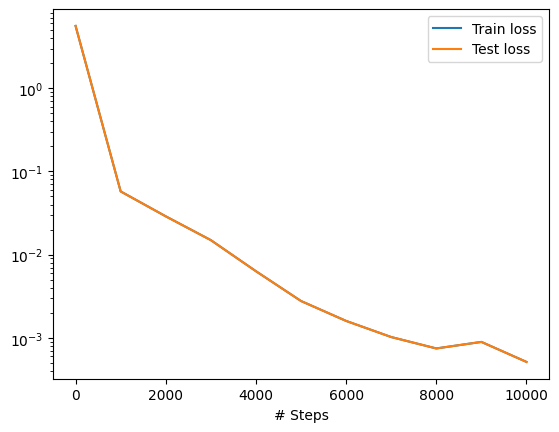

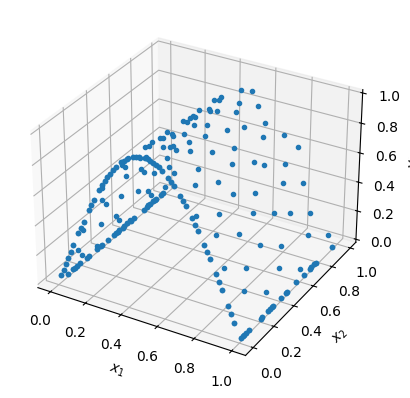

In [ ]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [ ]:
class RBFsKAN(nn.Module):
  def __init__(self, layers, kernel_type='gaussian'):
    super().__init__()
    self.layers = layers
    self.kernel_type = kernel_type

    self.centers = nn.ParameterList()
    self.sigmas = nn.ParameterList()
    self.linear_layers = nn.ModuleList()

    for i in range(len(layers)-1):
      centers = torch.randn(layers[i], layers[i+1]) * 0.1
      sigmas = torch.ones(layers[i+1])
      nn.init.uniform_(sigmas, 0.5, 2.0)

      self.centers.append(nn.Parameter(centers))
      self.sigmas.append(nn.Parameter(sigmas))
      self.linear_layers.append(nn.Linear(layers[i], layers[i+1]))

  def kernel_function(self, x, centers, sigma):
    for i in range(len(self.layers)-1):
      if self.kernel_type == 'gaussian':
        d = torch.cdist(x, centers.T)
        d_sq = torch.clamp(d**2, max=50)
        sigma = sigma.reshape(1, -1)
        return torch.exp(-d_sq/(2*sigma**2))

      elif self.kernel_type == 'multiquadric':
        d = torch.cdist(x, centers.T)
        d_sq = torch.clamp(d**2, max=50)
        sigma = sigma.reshape(1, -1)
        return torch.sqrt(d_sq + sigma**2)

      else:
        raise ValueError(f'Unknown kernel type: {self.kernel_type}')

  def forward(self, x):
    for i in range(len(self.layers)-1):
      if i == 0:
        kernel_out = self.kernel_function(x, self.centers[i], self.sigmas[i])
        linear_out = self.linear_layers[i](x)
        out = kernel_out + linear_out

      else:
        kernel_out = self.kernel_function(out, self.centers[i], self.sigmas[i])
        linear_out = self.linear_layers[i](out)
        out = kernel_out + linear_out

      if i == len(self.layers)-2:
        out = torch.tanh(out)

      else:
        out = torch.tanh(out)

    return out

In [ ]:
class RBFsKANWrapper(dde.nn.pytorch.NN):
  def __init__(self, layers, kernel_type='gaussian'):
    super().__init__()
    self.rbfskan = RBFsKAN(layers, kernel_type)

  def forward(self, x):
    x_normalized = (x-x.mean(dim=0))/(x.std(dim=0)+1e-8)
    return self.rbfskan(x_normalized)

In [ ]:
layers = [2] + [50]*3 + [1]

In [ ]:
net1 = RBFsKANWrapper(layers=layers, kernel_type='gaussian')

In [ ]:
model1 = dde.Model(data, net1)

In [ ]:
model1.compile('adam', lr=1e-4, loss_weights=[1, 10, 10, 10])

Compiling model...
'compile' took 0.000390 s



In [ ]:
losshistory, train_state = model1.train(iterations=10000, display_every=1000)

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.39e-02, 1.55e+00, 1.70e+00, 1.18e+00]    [1.39e-02, 1.55e+00, 1.70e+00, 1.18e+00]    []  
1000      [2.20e-02, 1.76e-02, 5.72e-04, 7.85e-04]    [2.20e-02, 1.76e-02, 5.72e-04, 7.85e-04]    []  
2000      [3.44e-03, 7.00e-03, 2.08e-04, 3.25e-04]    [3.44e-03, 7.00e-03, 2.08e-04, 3.25e-04]    []  
3000      [1.07e-03, 4.29e-03, 1.32e-04, 1.86e-04]    [1.07e-03, 4.29e-03, 1.32e-04, 1.86e-04]    []  
4000      [5.74e-04, 2.52e-03, 5.96e-05, 7.83e-05]    [5.74e-04, 2.52e-03, 5.96e-05, 7.83e-05]    []  
5000      [3.26e-04, 1.33e-03, 2.69e-05, 2.49e-05]    [3.26e-04, 1.33e-03, 2.69e-05, 2.49e-05]    []  
6000      [2.50e-04, 6.96e-04, 1.34e-05, 1.39e-05]    [2.50e-04, 6.96e-04, 1.34e-05, 1.39e-05]    []  
7000      [1.84e-04, 3.95e-04, 7.30e-06, 7.53e-06]    [1.84e-04, 3.95e-04, 7.30e-06, 7.53e-06]    []  
8000      [1.37e-04, 2.36e-04, 4.35e-06, 4.34e-

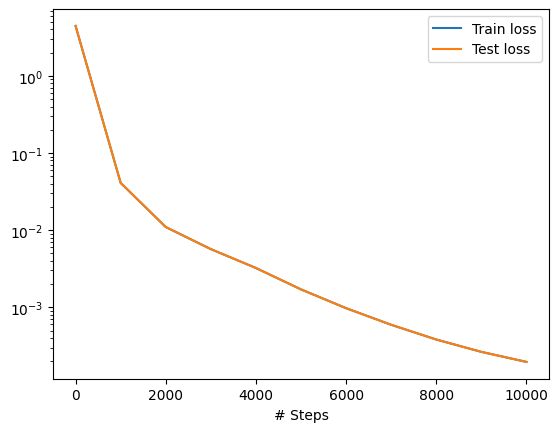

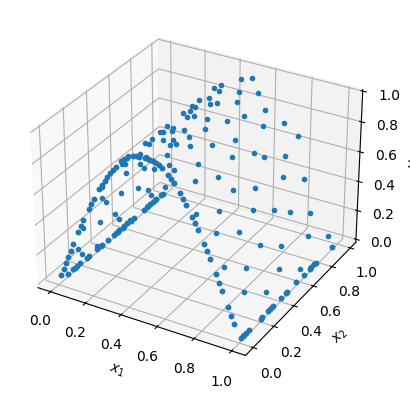

In [ ]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [ ]:
class cKAN(nn.Module):
  def __init__(self, layers, degree=3):
    super().__init__()
    self.layers = layers
    self.degree = degree
    self.linear_layers = nn.ModuleList()
    for i in range(len(layers)-1):
      in_expand = layers[i] * (degree+1)
      out_dim = layers[i+1]
      self.linear_layers.append(nn.Linear(in_expand, out_dim))

  def cheb_basis(self, x, degree):
    x = x.float()
    b, f = x.shape
    T = []

    T0 = torch.ones_like(x)
    T.append(T0)

    if degree >= 1:
      T1 = x.clone()
      T.append(T1)

    for k in range(2, degree+1):
      T_k = 2*x*T[-1] - T[-2]
      T.append(T_k)

    T_stack = torch.stack(T, dim=0)
    T_stack = T_stack.permute(1, 2, 0)
    expanded = T_stack.reshape(b, f*(degree+1))
    return expanded

  def forward(self, x):
    out = x
    for i in range(len(self.layers)-1):
      x_exp = self.cheb_basis(out, self.degree)
      linear_out = self.linear_layers[i](x_exp)
      out = torch.tanh(linear_out)
    return out

class cKANWrapper(dde.nn.pytorch.NN):
  def __init__(self, layers, degree=3):
    super().__init__()
    self.ckan = cKAN(layers, degree)

  def forward(self, x):
    return self.ckan(x)


In [ ]:
net2 = cKANWrapper(layers=layers, degree=3)

In [ ]:
model2 = dde.Model(data, net2)

In [ ]:
model2.compile('adam', lr=1e-4, loss_weights=[1, 10, 10, 10])

Compiling model...
'compile' took 0.000255 s



In [ ]:
losshistory, train_state = model2.train(iterations=10000, display_every=1000)

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.09e-02, 1.40e+01, 2.77e+00, 1.34e+00]    [1.09e-02, 1.40e+01, 2.77e+00, 1.34e+00]    []  
1000      [3.29e-03, 1.39e-02, 1.90e-04, 2.52e-05]    [3.29e-03, 1.39e-02, 1.90e-04, 2.52e-05]    []  
2000      [1.79e-03, 6.56e-03, 1.01e-04, 4.28e-06]    [1.79e-03, 6.56e-03, 1.01e-04, 4.28e-06]    []  
3000      [8.00e-04, 3.20e-03, 5.19e-05, 1.26e-06]    [8.00e-04, 3.20e-03, 5.19e-05, 1.26e-06]    []  
4000      [3.68e-04, 1.66e-03, 1.80e-05, 1.45e-06]    [3.68e-04, 1.66e-03, 1.80e-05, 1.45e-06]    []  
5000      [1.75e-04, 9.75e-04, 5.42e-06, 5.34e-07]    [1.75e-04, 9.75e-04, 5.42e-06, 5.34e-07]    []  
6000      [1.10e-04, 6.46e-04, 5.52e-06, 1.53e-06]    [1.10e-04, 6.46e-04, 5.52e-06, 1.53e-06]    []  
7000      [8.19e-05, 4.69e-04, 7.61e-06, 3.40e-06]    [8.19e-05, 4.69e-04, 7.61e-06, 3.40e-06]    []  
8000      [6.78e-05, 3.58e-04, 1.10e-06, 1.60e-

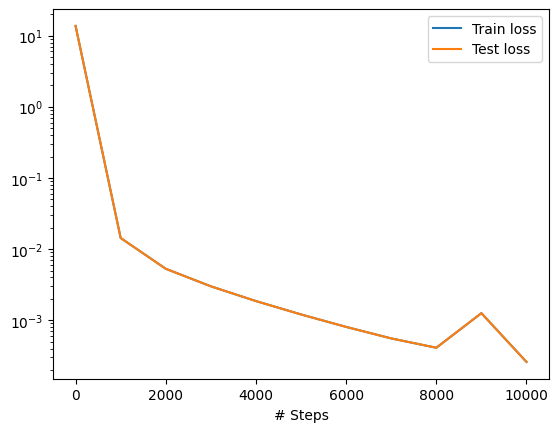

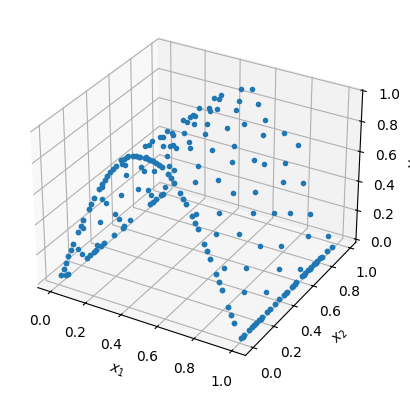

In [ ]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)